In [1]:
# eda10_00 clear all variables and import vatious modules
%reset -f
import os
from datetime import date
from math import exp, pi, sin, cos, tan, sqrt, floor, ceil, log
import numpy as np
import scipy.sparse.linalg as las
import scipy.interpolate as ip
import scipy.spatial as sp
from scipy import sparse
import scipy.linalg as la
import scipy.signal as sg
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

# eda_draw function makes a "pictorial matrix equation"
# arguments are vectors, matrices and strings
# which are plotted in the order that the appear
# except that strings starting with 'title ' are plotted
# under the subseqeunt matrix or vector
# always returns a status of 1

def eda_draw(*argv):
    bw = np.zeros((256,4));
    v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
    bw[:,0] = v;
    bw[:,1] = v;
    bw[:,2] = v;
    bw[:,3] = np.ones(256);
    bwcmap = ListedColormap(bw);
    # size of plot
    W = 16;
    H = 4;
    fig1 = plt.figure(1);
    # figsize width and height in inches
    fig1.set_size_inches(W,H);
    ax1 = plt.subplot(1,1,1);
    plt.axis([0, W, -H/2, H/2]);
    plt.axis('off');
    LM = W/6;    # matrix width and heoght
    LV = W/40;   # vector width
    FS = 0.12;    # character width
    TO = 0.4;    # title vertical offset
    SP = 0.2;    # space between objects
    LS = 0.2;    # leading space
    p = LS; # starting x-position
    istitle=0; # flags presence of a title
    for a in argv:
        if isinstance(a,np.ndarray):
            sh = np.shape(a);
            if len(sh) == 1:  # conversion to nx1 array
                n = sh[0];
                m = 1;
                ap = a;
                a = np.zeros((n,1));
                a[:,0] = ap;
            else:
                n = sh[0];
                m = sh[1];
            if m==1:
                pold=p;
                left=p;
                right=p+LV;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LV;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
            else:
                pold=p;
                left=p;
                right=p+LM;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LM;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
        elif isinstance(a,str):
            ns = len(a);
            istitle=0;
            if( ns>=6 ):
                if 'title ' in a[0:6]:
                    istitle=1;
                    titlestr=a[6:];
            if( istitle != 1):
                plt.text(p,0,a);
                p = p + ns*FS + SP;
    plt.show();
    return 1;


def FTFmul(v):
    # this function is used by the bicongugate gradient solver to solve the geneneralized least
    # squares problem Fm=f.  Note that "F" must be called "edaFsparse".
    global edaFsparse;
    s = np.shape(v);
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    temp = edaFsparse*vv;
    return edaFsparse.transpose()*temp;


def GLSFilterMul(v):
    # this function is used by the bicongugate gradient solver to solve the
    # geneneralized least squares problem Fm=f with F=[G;H] and f=[d,h],
    # where G is a topplitz matrix built from the filter g
    # Note that "H" must be sparese and called "edaHsparse" and that
    # the filter "g" bust be called edafilterg and must be a column vector
    global edaHsparse;
    global edafilterg;
    # rearrange as column-vector
    s = np.shape(v);
    M = s[0];
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    N, i = np.shape(edafilterg);
    # implements (GT G + HT H) v
    temp1 = np.zeros((N+M-1,1));
    temp1[:,0] = np.convolve(edafilterg.ravel(),vv.ravel()); # G v is of length N
    a = np.zeros((N,1));
    a[:,0] = temp1[0:N,0];
    b = edaHsparse * v; # H v is of length K
    temp2 = np.zeros((N+N-1,1));
    temp2[:,0] = np.convolve((np.flipud(edafilterg)).ravel(),a.ravel()); # GT (G v) is of length M
    a2 = temp2[N-1:N+M-1,0];
    b2 = edaHsparse.transpose()*b; # HT (H v) is of length M
    # FT F v = GT G v + HT H v
    return (a2+b2);


def GLSautoMul(v):
    # this function is used by the bicongugate gradient solver to solve the
    # geneneralized least squares problem Fm=f with F=[G;H] and f=[d,h],
    # where GTG is built from the autocorrelation of the filter g
    global edaHsparse;
    global edaautoc;
    # rearrange as column-vector
    s = np.shape(v);
    M = s[0];
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    # FT F v = GT G v + HT H v
    GTGv=np.zeros((M,1));
    for i in range(M):
        u = np.concatenate( (np.flipud(edaautoc[0:i+1,0]), edaautoc[1:M-i,0]), axis=0 );
        GTGv[i,0] =  np.matmul( u.T, vv );
    Hv = edaHsparse*vv;
    HTHv = edaHsparse.transpose()*Hv;
    return (GTGv + HTHv);


def chebyshevfilt(d, Dt, flow, fhigh):
    #chebyshevfilt
    # chebyshev IIR bandpass filter
    # d - input array of data
    # Dt - sampling interval
    # flow - low pass frequency, Hz
    # fhigh - high pass frequency, Hz
    # dout - output array of data
    # u - the numerator filter
    # v - the denominator filter
    # these filters can be used again using dout=filter(u,v,din);

    # make sure input timeseries is a column vector
    s = np.shape(d);
    N = s[0];
    if(N==1):
        dd = np.zeros((N,1));
        dd[:,0] = d;
    else:
        dd=d;
        
    # sampling rate
    rate=1/Dt;

    # ripple parameter, set to ten percent
    ripple=0.1;  

    # normalise frequency
    fl=2.0*flow/rate;
    fh=2.0*fhigh/rate;

    # center frequency 
    cf = 4 * tan( (fl*pi/2) ) * tan( (fh*pi/2) );

    # bandwidth
    bw = 2 * ( tan( (fh*pi/2) ) - tan( (fl*pi/2) ) );

    # ripple parameter factor
    rpf = sqrt((sqrt((1.0+1.0/(ripple*ripple))) + 1.0/ripple));
    a = 0.5*(rpf-1.0/rpf);
    b = 0.5*(rpf+1.0/rpf);

    u=np.zeros((5,1));
    v=np.zeros((5,1));
    theta = 3*pi/4;
    sr = a * cos(theta);
    si = b * sin(theta);
    es = sqrt(sr*sr+si*si);
    tmp= 16.0 - 16.0*bw*sr + 8.0*cf + 4.0*es*es*bw*bw - 4.0*bw*cf*sr + cf*cf;
    v[0,0] = 1.0;
    v[1,0] = 4.0*(-16.0 + 8.0*bw*sr - 2.0*bw*cf*sr + cf*cf)/tmp;
    v[2,0] = (96.0 - 16.0*cf - 8.0*es*es*bw*bw + 6.0*cf*cf)/tmp;
    v[3,0] = (-64.0 - 32.0*bw*sr + 8.0*bw*cf*sr + 4.0*cf*cf)/tmp;
    v[4,0] = (16.0 + 16.0*bw*sr + 8.0*cf + 4.0*es*es*bw*bw + 4.0*bw*cf*sr + cf*cf)/tmp;
    tmp = 4.0*es*es*bw*bw/tmp;
    u[0,0] = tmp;
    u[1,0] = 0.0;
    u[2,0] = -2.0*tmp;
    u[3,0] = 0.0;
    u[4,0] = tmp;

    dout = sg.lfilter(u.ravel(),v.ravel(),dd.ravel());
    return (dout,u,v);



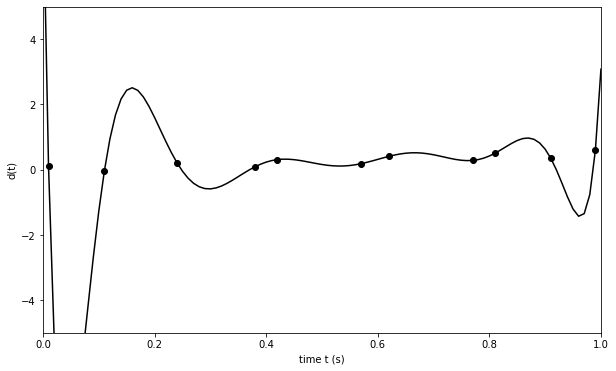

In [2]:
# eda10_01
# illustrate problem associated with interpolation by
# fitting a high-order polynomial

# times
N=11;
t = np.zeros((N,1));
t[:,0] = [0.01, 0.11, 0.24, 0.38, 0.42, 0.57, 0.62, 0.77, 0.81, 0.91, 0.99];


# simple function
d = np.zeros((N,1));
d[:,0] = t.ravel()/2 + [0.1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1];

# plot simple function
fig1 = plt.figure(1,figsize=(10,6));
plt.axis([0, 1, -5, 5]);
plt.plot( t, d, 'ko');
plt.xlabel('time t (s)');
plt.ylabel('d(t)');

# linear representation of polynomial relationship
G=np.zeros((N,N));
for i in range(N):
    G[:,i]=np.power(t,i).ravel();

# solve for coefficients
m = la.solve(G,d);

# evaluate at equally-spaced values of t
Np=101;
tp = np.zeros((Np,1));
tp[:,0] = np.linspace(0,1,Np);
Gp = np.zeros((Np,N));
for i in range(N):
    Gp[:,i] = np.power( tp, i ).ravel();
dp = np.matmul(Gp,m);

# plot simple function
plt.plot(tp,dp,'k-');
plt.show();


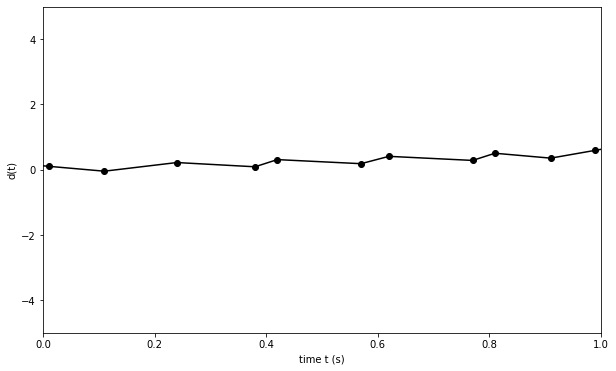

In [3]:
# eda10_02
# example of linear interpolation

# times
N=11;
t = np.zeros((N,1));
t[:,0] = [0.01, 0.11, 0.24, 0.38, 0.42, 0.57, 0.62, 0.77, 0.81, 0.91, 0.99];


# simple function
d = np.zeros((N,1));
d[:,0] = t.ravel()/2 + [0.1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1];

# plot simple function
fig1 = plt.figure(1,figsize=(10,6));
plt.axis([0, 1, -5, 5]);
plt.plot( t, d, 'ko');
plt.xlabel('time t (s)');
plt.ylabel('d(t)');

# qually-spaced values of t
Np=101;
tp = np.zeros((Np,1));
tp[:,0] = np.linspace(0,1,Np);

# linear interpolation
f = ip.interp1d(t.ravel(),d.ravel(),axis=0,kind='linear',fill_value='extrapolate');
dp = np.zeros((Np,1));
dp[:,0]=f(tp.ravel());

# plot simple function
plt.plot(tp,dp,'k-');
plt.show();

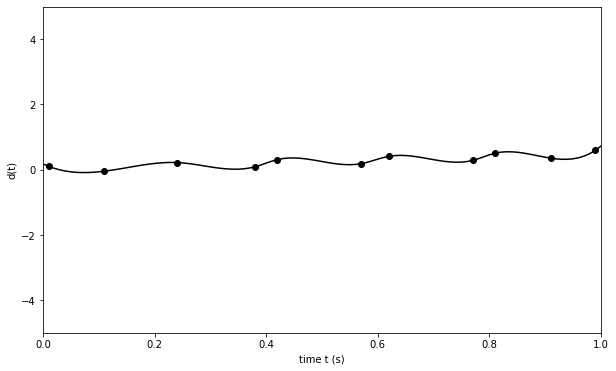

In [4]:
# eda10_03
# example of  ubic spline interpolation

# times
N=11;
t = np.zeros((N,1));
t[:,0] = [0.01, 0.11, 0.24, 0.38, 0.42, 0.57, 0.62, 0.77, 0.81, 0.91, 0.99];


# simple function
d = np.zeros((N,1));
d[:,0] = t.ravel()/2 + [0.1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1];

# plot simple function
fig1 = plt.figure(1,figsize=(10,6));
plt.axis([0, 1, -5, 5]);
plt.plot( t, d, 'ko');
plt.xlabel('time t (s)');
plt.ylabel('d(t)');

# qually-spaced values of t
Np=101;
tp = np.zeros((Np,1));
tp[:,0] = np.linspace(0,1,Np);

# linear interpolation
f = ip.interp1d(t.ravel(),d.ravel(),axis=0,kind='cubic',fill_value='extrapolate');
dp = np.zeros((Np,1));
dp[:,0]=f(tp.ravel());

# plot simple function
plt.plot(tp,dp,'k-');
plt.show();

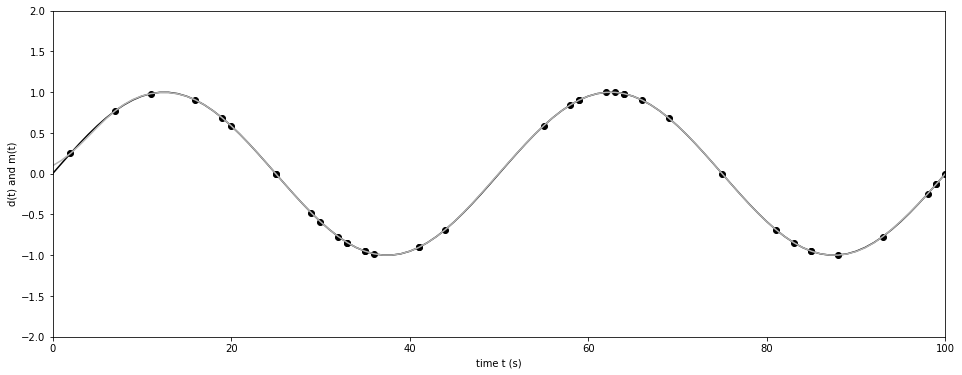

In [5]:
# eda10_04
# simple example of kriging

# the model parameters are the values of a sinusoidal
# function evenly spaced along the t axis
M=101;
Dt=1.0;
tmin=0;
t = np.zeros((M,1));
t[:,0] = tmin+Dt*np.linspace(0,M-1,M);
tmax=t[M-1,0];

# the true model parameters are sinusoidally varying
freq=0.02;
mtrue = np.zeros((M,1));
mtrue[:,0] = np.sin(2*pi*freq*t).ravel();

# the data are the values the function measured on only a
# subset of randomply chosen points along the x axis
N=40;
rowindex = np.sort( np.random.randint(M,size=N) );
tobs = np.zeros((N,1));
tobs[:,0]=t[rowindex,:].ravel();
dobs = np.zeros((N,1));
dobs[:,0] = mtrue[rowindex,:].ravel();

# estimate the model parameters at these points
test = t;

# plot the observed data with circles
fig1 = plt.figure(1,figsize=(16,6));
plt.axis([tmin, tmax, -2, 2]);
plt.plot( t, mtrue, 'k-');
plt.plot( tobs, dobs, 'ko');
plt.xlabel('time t (s)');
plt.ylabel('d(t) and m(t)');

# assume the autocorrelation function of the data
# is a a Normal function with variance L^2.  The normalization
# constant cancels, so just set to unity

# set the constant L arbitrarily
L2 = 20;

# basics equations are Aw=v(i), dest(i)=dobs'*w(i);

# set up the kriging matrix, A
wN = np.ones((N,1));
wM = np.ones((M,1));
# MATLAB A = exp(-abs(tobs*ones(N,1)'-ones(N,1)*tobs').^2 /(2*L2));
A = np.exp( -np.power(np.abs(np.matmul(tobs,wN.T)-np.matmul(wN,tobs.T)), 2) / (2*L2) );

# set up kriging vector, v, but with vector for each interplation
# point a column of the matrix, V
# MATLAB V = exp(-abs(tobs*ones(M,1)'-ones(N,1)* test').^2 /(2*L2));
V = np.exp( -np.power(np.abs(np.matmul(tobs,wM.T)-np.matmul(wN,test.T)), 2) / (2*L2) );

# solve, but add some damping, just in case A is near singular.  This selects the smallest w
# that solves the equation
# MATLAB dest=dobs'*((A+1e-6*eye(N))\V);
e = 1.0e-6; 
mest = np.zeros((M,1));
mest[:,0] = np.matmul( dobs.T, la.solve(A+e*np.identity(N),V) );
    
# plot estimated data with line
plt.plot(test,mest,'k-',color=(0.7,0.7,0.7));
plt.show();


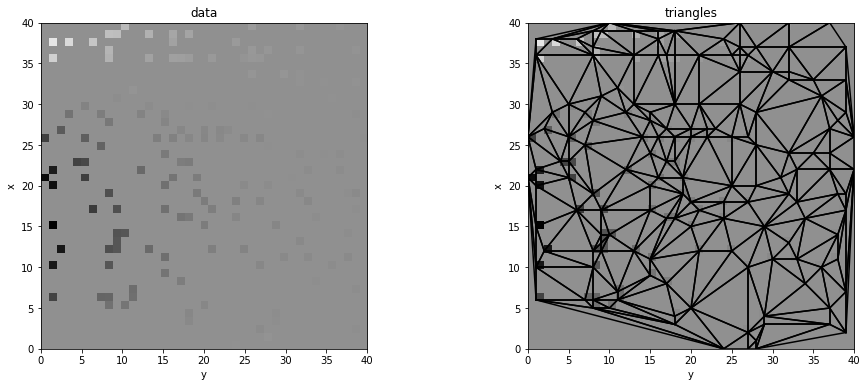

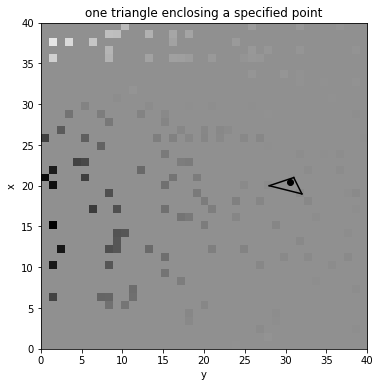

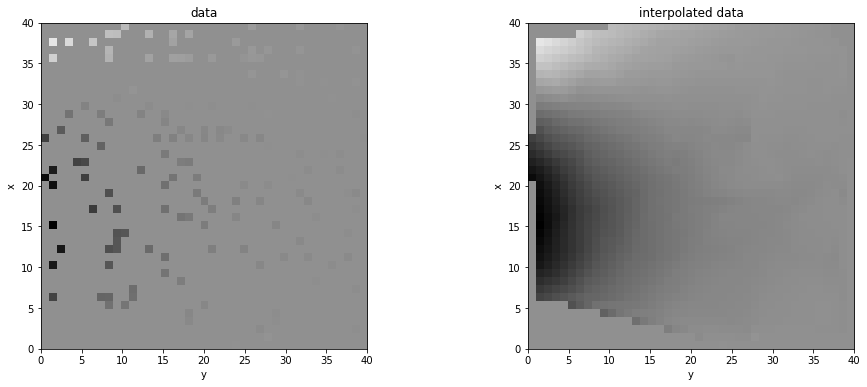

In [56]:
# eda10_05
# 2D interpolation of simulated pressure data
# this script
#             creates simulated data (Figue 1a)
#             creates Delaunay triangle mesh (Figure 1b)
#             finds triangle enclosing an arbitrary point (Figure 2)
#             linear interpolation (Figure 3)


# rows of grid are x
I = 41;
Dx = 1;
xmin = 0;
xmax = 40;
x = np.zeros((I,1));
x[:,0] = xmin + (xmax-xmin)*np.linspace(0,I-1,I)/(I-1);

# columns of grid are y
J = 41;
Dy = 1;
ymin = 0;
ymax = 40;
y = np.zeros((I,1));
y[:,0] = ymin + (ymax-ymin)*np.linspace(0,J-1,J)/(J-1);

# grid 10% populated with data
N0 = floor(I*J/10);
rowindex0=np.zeros((N0,1),dtype=np.int);
colindex0=np.zeros((N0,1),dtype=np.int);
rowindex0[:,0]=np.random.randint(I,size=N0);
colindex0[:,0]=np.random.randint(J,size=N0);

# remove duplicate points, because the interpolation
# function doesn't seem to like them, by checking
# eack point against a matrix F of ones and zeros
F = np.zeros((I,J),dtype=np.int);
rowindex1=np.zeros((N0,1),dtype=np.int);
colindex1=np.zeros((N0,1),dtype=np.int);
N=0;
for i in range(N0):
    irow = rowindex0[i,0];
    icol = colindex0[i,0];
    if ( F[irow,icol] == 0 ):
        rowindex1[N,0]=irow;
        colindex1[N,0]=icol;
        N=N+1;
        F[irow,icol] = 1;
rowindex=np.zeros((N,1),dtype=np.int);
colindex=np.zeros((N,1),dtype=np.int);                
rowindex[:,0]=rowindex1[0:N,0];
colindex[:,0]=colindex1[0:N,0];
xobs = x[rowindex,0];
yobs = y[colindex,0];

# create simulated pressure data (solution to Laplace's equation)
kappa = 0.1;
dtrue = 10*np.multiply( np.sin(kappa*xobs), np.exp(-kappa*yobs) );
sigmad = 0.1;
dobs = dtrue + np.random.normal(0.0,sigmad,(N,1) );

# populate matrix A with observations
A = np.zeros((I,J));
for i in range(N):
    A[rowindex[i,0],colindex[i,0]] = dobs[i,0];

# B&W colormap
bw = np.zeros((256,4));
v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
bw[:,0] = v;
bw[:,1] = v;
bw[:,2] = v;
bw[:,3] = np.ones(256);
bwcmap = ListedColormap(bw);
    
fig1 = plt.figure(1,figsize=(16,6));
ax1 = plt.subplot(1,2,1);
plt.axis([ymin, ymax, xmin, xmax]);
left=ymin;
right=ymax;
bottom=xmin;
top=xmax;
plt.imshow( np.flipud(A), cmap=bwcmap, vmin=np.min(A), vmax=np.max(A), extent=(left,right,bottom,top) );
plt.xlabel('y');
plt.ylabel('x');
plt.title('data');

# triangulation
XY = np.concatenate( (xobs,yobs), axis=1 );
mytri = sp.Delaunay( XY  );

# plot triangles
TRI = mytri.simplices;
[NTRI, i] = np.shape(TRI);

# plot
ax1 = plt.subplot(1,2,2);
plt.axis([ymin, ymax, xmin, xmax]);
left=ymin;
right=ymax;
bottom=xmin;
top=xmax;
plt.imshow( np.flipud(A), cmap=bwcmap, vmin=np.min(A), vmax=np.max(A), extent=(left,right,bottom,top) );
for i in range(NTRI):
    v1=TRI[i,0];
    v2=TRI[i,1];
    v3=TRI[i,2];
    plt.plot( [XY[v1,1], XY[v2,1]], [XY[v1,0], XY[v2,0]], 'k-');
    plt.plot( [XY[v2,1], XY[v3,1]], [XY[v2,0], XY[v3,0]], 'k-');
    plt.plot( [XY[v3,1], XY[v1,1]], [XY[v3,0], XY[v1,0]], 'k-');
plt.xlabel('y');
plt.ylabel('x');
plt.title('triangles');
plt.show();

fig2 = plt.figure(2,figsize=(16,6));
ax1 = plt.subplot(1,1,1);
plt.axis([ymin, ymax, xmin, xmax]);
left=ymin;
right=ymax;
bottom=xmin;
top=xmax;
plt.imshow( np.flipud(A), cmap=bwcmap, vmin=np.min(A), vmax=np.max(A), extent=(left,right,bottom,top) );
plt.xlabel('y');
plt.ylabel('x');
plt.title('one triangle enclosing a specified point');

# find triangle enclosing exemplary point and plot them
x0=[20.5,30.5];
k = mytri.find_simplex( x0 );
if( k != -1 ):
    plt.plot( x0[1], x0[0], 'ko');
    v1=TRI[k,0];
    v2=TRI[k,1];
    v3=TRI[k,2];
    plt.plot( [XY[v1,1], XY[v2,1]], [XY[v1,0], XY[v2,0]], 'k-');
    plt.plot( [XY[v2,1], XY[v3,1]], [XY[v2,0], XY[v3,0]], 'k-');
    plt.plot( [XY[v3,1], XY[v1,1]], [XY[v3,0], XY[v1,0]], 'k-'); 
plt.show();

# 2D interpolation
XGRID = np.matmul( x, np.ones((1,J)) );
YGRID = np.matmul( np.ones((I,1)), y.T );
# note: could also use method='cubic' for smoother interpolation
BB=ip.griddata( np.concatenate((xobs,yobs),axis=1),dobs,(XGRID,YGRID), method='linear', fill_value=0.0);
B = BB[:,:,0];

# plot
fig3 = plt.figure(3,figsize=(16,6));
ax1 = plt.subplot(1,2,1);
plt.axis([ymin, ymax, xmin, xmax]);
left=ymin;
right=ymax;
bottom=xmin;
top=xmax;
plt.imshow( np.flipud(A), cmap=bwcmap, vmin=np.min(A), vmax=np.max(A), extent=(left,right,bottom,top) );
plt.xlabel('y');
plt.ylabel('x');
plt.title('data');
ax1 = plt.subplot(1,2,2);
plt.axis([ymin, ymax, xmin, xmax]);
left=ymin;
right=ymax;
bottom=xmin;
top=xmax;
plt.imshow( np.flipud(B), cmap=bwcmap, vmin=np.min(B), vmax=np.max(B), extent=(left,right,bottom,top) );
plt.xlabel('y');
plt.ylabel('x');
plt.title('interpolated data');
plt.show();




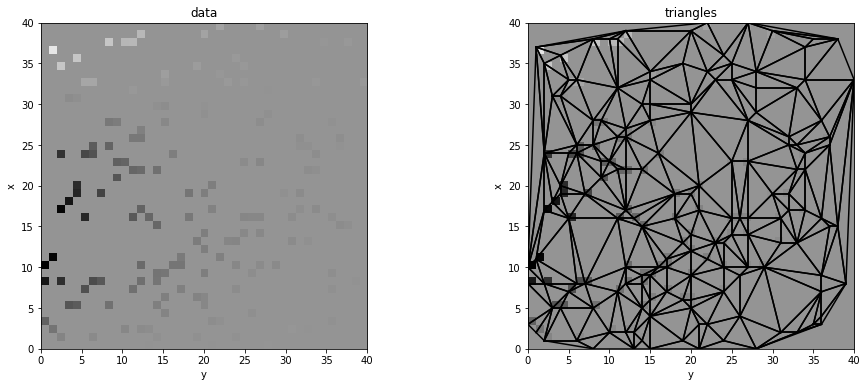

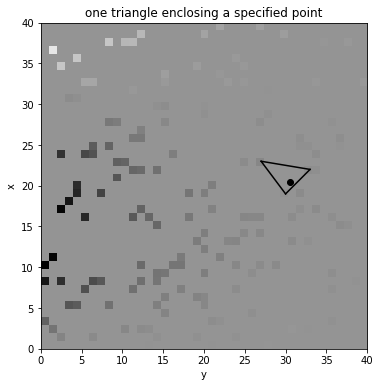

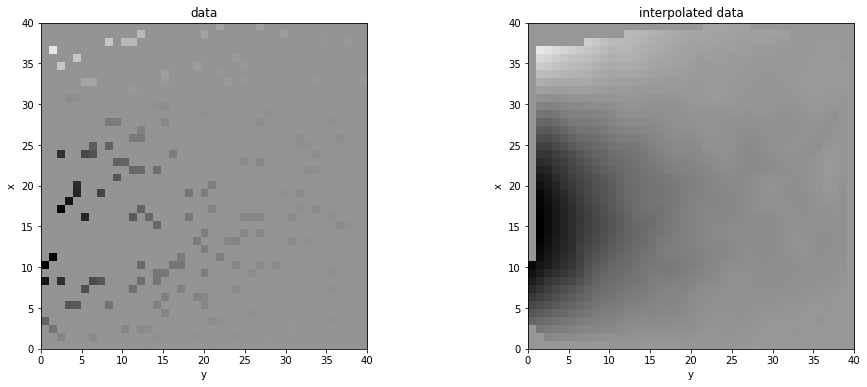

In [6]:
# eda10_06
# 2D interpolation of simulated pressure data
# this script
#             creates simulated data (Figue 1a)
#             creates Delaunay triangle mesh (Figure 1b)
#             finds triangle enclosing an arbitrary point (Figure 2)
#             cubic spline interpolation (Figure 3)

# rows of grid are x
I = 41;
Dx = 1;
xmin = 0;
xmax = 40;
x = np.zeros((I,1));
x[:,0] = xmin + (xmax-xmin)*np.linspace(0,I-1,I)/(I-1);

# columns of grid are y
J = 41;
Dy = 1;
ymin = 0;
ymax = 40;
y = np.zeros((I,1));
y[:,0] = ymin + (ymax-ymin)*np.linspace(0,J-1,J)/(J-1);

# grid 10% populated with data
N0 = floor(I*J/10);
rowindex0=np.zeros((N0,1),dtype=np.int);
colindex0=np.zeros((N0,1),dtype=np.int);
rowindex0[:,0]=np.random.randint(I,size=N0);
colindex0[:,0]=np.random.randint(J,size=N0);

# remove duplicate points, because the interpolation
# function doesn't seem to like them, by checking
# eack point against a matrix F of ones and zeros
F = np.zeros((I,J),dtype=np.int);
rowindex1=np.zeros((N0,1),dtype=np.int);
colindex1=np.zeros((N0,1),dtype=np.int);
N=0;
for i in range(N0):
    irow = rowindex0[i,0];
    icol = colindex0[i,0];
    if ( F[irow,icol] == 0 ):
        rowindex1[N,0]=irow;
        colindex1[N,0]=icol;
        N=N+1;
        F[irow,icol] = 1;
rowindex=np.zeros((N,1),dtype=np.int);
colindex=np.zeros((N,1),dtype=np.int);                
rowindex[:,0]=rowindex1[0:N,0];
colindex[:,0]=colindex1[0:N,0];
xobs = x[rowindex,0];
yobs = y[colindex,0];

# create simulated pressure data (solution to Laplace's equation)
kappa = 0.1;
dtrue = 10*np.multiply( np.sin(kappa*xobs), np.exp(-kappa*yobs) );
sigmad = 0.1;
dobs = dtrue + np.random.normal(0.0,sigmad,(N,1) );

# populate matrix A with observations
A = np.zeros((I,J));
for i in range(N):
    A[rowindex[i,0],colindex[i,0]] = dobs[i,0];

# B&W colormap
bw = np.zeros((256,4));
v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
bw[:,0] = v;
bw[:,1] = v;
bw[:,2] = v;
bw[:,3] = np.ones(256);
bwcmap = ListedColormap(bw);
    
fig1 = plt.figure(1,figsize=(16,6));
ax1 = plt.subplot(1,2,1);
plt.axis([ymin, ymax, xmin, xmax]);
left=ymin;
right=ymax;
bottom=xmin;
top=xmax;
plt.imshow( np.flipud(A), cmap=bwcmap, vmin=np.min(A), vmax=np.max(A), extent=(left,right,bottom,top) );
plt.xlabel('y');
plt.ylabel('x');
plt.title('data');

# triangulation
XY = np.concatenate( (xobs,yobs), axis=1 );
mytri = sp.Delaunay( XY  );

# plot triangles
TRI = mytri.simplices;
[NTRI, i] = np.shape(TRI);

# plot
ax1 = plt.subplot(1,2,2);
plt.axis([ymin, ymax, xmin, xmax]);
left=ymin;
right=ymax;
bottom=xmin;
top=xmax;
plt.imshow( np.flipud(A), cmap=bwcmap, vmin=np.min(A), vmax=np.max(A), extent=(left,right,bottom,top) );
for i in range(NTRI):
    v1=TRI[i,0];
    v2=TRI[i,1];
    v3=TRI[i,2];
    plt.plot( [XY[v1,1], XY[v2,1]], [XY[v1,0], XY[v2,0]], 'k-');
    plt.plot( [XY[v2,1], XY[v3,1]], [XY[v2,0], XY[v3,0]], 'k-');
    plt.plot( [XY[v3,1], XY[v1,1]], [XY[v3,0], XY[v1,0]], 'k-');
plt.xlabel('y');
plt.ylabel('x');
plt.title('triangles');
plt.show();

fig2 = plt.figure(2,figsize=(16,6));
ax1 = plt.subplot(1,1,1);
plt.axis([ymin, ymax, xmin, xmax]);
left=ymin;
right=ymax;
bottom=xmin;
top=xmax;
plt.imshow( np.flipud(A), cmap=bwcmap, vmin=np.min(A), vmax=np.max(A), extent=(left,right,bottom,top) );
plt.xlabel('y');
plt.ylabel('x');
plt.title('one triangle enclosing a specified point');

# find triangle enclosing exemplary point and plot them
x0=[20.5,30.5];
k = mytri.find_simplex( x0 );
if( k != -1 ):
    plt.plot( x0[1], x0[0], 'ko');
    v1=TRI[k,0];
    v2=TRI[k,1];
    v3=TRI[k,2];
    plt.plot( [XY[v1,1], XY[v2,1]], [XY[v1,0], XY[v2,0]], 'k-');
    plt.plot( [XY[v2,1], XY[v3,1]], [XY[v2,0], XY[v3,0]], 'k-');
    plt.plot( [XY[v3,1], XY[v1,1]], [XY[v3,0], XY[v1,0]], 'k-'); 
plt.show();

# 2D interpolation
XGRID = np.matmul( x, np.ones((1,J)) );
YGRID = np.matmul( np.ones((I,1)), y.T );
# note: could also use method='linear' for less-smooth interpolation
BB=ip.griddata( np.concatenate((xobs,yobs),axis=1),dobs,(XGRID,YGRID), method='cubic', fill_value=0.0);
B = BB[:,:,0];

# plot
fig3 = plt.figure(3,figsize=(16,6));
ax1 = plt.subplot(1,2,1);
plt.axis([ymin, ymax, xmin, xmax]);
left=ymin;
right=ymax;
bottom=xmin;
top=xmax;
plt.imshow( np.flipud(A), cmap=bwcmap, vmin=np.min(A), vmax=np.max(A), extent=(left,right,bottom,top) );
plt.xlabel('y');
plt.ylabel('x');
plt.title('data');
ax1 = plt.subplot(1,2,2);
plt.axis([ymin, ymax, xmin, xmax]);
left=ymin;
right=ymax;
bottom=xmin;
top=xmax;
plt.imshow( np.flipud(B), cmap=bwcmap, vmin=np.min(B), vmax=np.max(B), extent=(left,right,bottom,top) );
plt.xlabel('y');
plt.ylabel('x');
plt.title('interpolated data');
plt.show();



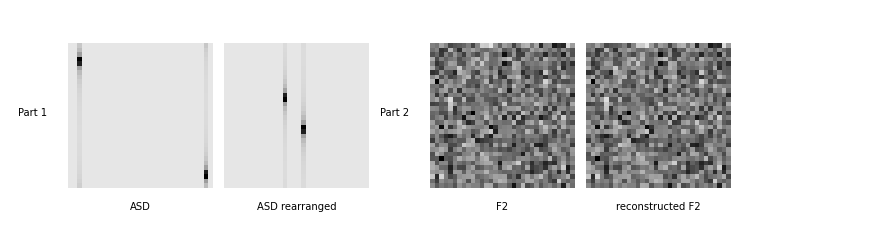

Symmetry test:
    error in transform 0.0000
    error in function  0.0000


In [7]:
# eda10_07
# illustrate two-dimensional fourier transform
# Part 1, FFT of cosine wave, reordered so zero us in center
# Part 2, Illustration of use of symmetry

# standard distance/wavenumber set up
Nx=32;
Nxo2 = floor(Nx/2);
Nkx=Nxo2+1;
Dx=1;
x = np.zeros((Nx,1));
x[:,0]=Dx*np.linspace(0,Nx-1,Nx);
xmax = Dx*(Nx-1);
kxmax=2*pi/(2*Dx);
Dkx=kxmax/(Nx/2);
kx=np.zeros((Nx,1));
kx[:,0] = Dkx * np.concatenate( ( np.linspace(0,Nxo2,Nkx), np.linspace(-Nxo2+1,-1,Nxo2-1) ), axis=0 );

Ny=32;
Nyo2 = floor(Ny/2);               
Nky=Nyo2+1;
Dy=1;
y = np.zeros((Ny,1));
y[:,0]=Dy*np.linspace(0,Ny-1,Ny);
ymax = Dy*(Ny-1);
kymax=2*pi/(2*Dy);
Dky=kymax/(Ny/2);
ky=np.zeros((Ny,1));
ky[:,0] = Dky * np.concatenate( ( np.linspace(0,Nyo2,Nky), np.linspace(-Nyo2+1,-1,Nyo2-1) ), axis=0 );


# Part 1: cosine wave
theta = (pi/180)*30;
t1 = np.zeros((2,1));
t1[:,0] = [cos(theta), sin(theta)];
kr1 = kxmax/4;
F = np.zeros((Nx,Ny));
for n in range(Nx):
    for m in range(Ny):
        F[n,m] = cos( kr1*t1[0,0]*x[n,0] + kr1*t1[1,0]*y[m,0] );

# amplitude spectral density
Ftt = np.fft.fft2(F);
norm = ((Dx**2)/xmax) * ((Dy**2)/ymax);
Fasd = norm * np.sqrt( np.power( np.abs(Ftt), 2));

# put into more reasonable order, with zero in the center
Fasd2=np.zeros((Nx,Ny));
Fasd2[Nx-Nkx:Nx,Ny-Nky:Ny] = Fasd[0:Nkx,0:Nky];
Fasd2[0:Nkx-2,Ny-Nky:Ny] = Fasd[Nkx:Nx,0:Nky];
Fasd2[0:Nkx-2,0:Nky-2] = Fasd[Nkx:Nx,Nky:Ny];
Fasd2[Nkx-2:Nx,0:Nky-2] = Fasd[0:Nkx,Nky:Ny];

# Part 2: example of the use of symmetry

# new function F is noise, which has a complicated Fourier Transform
F=np.random.normal(0.0,1.0,(Nx,Ny) );
Ftt = np.fft.fft2(F);

# for real data, use symmetries to build right hand columns of
# 2D Fourier Transform from left hand columns
# First copy left Ny/2+1 columns; they are treated as known
Ftt2=np.zeros((Nx,Ny),dtype=np.complex);
Ftt2[:,0:Nky] = Ftt[:,0:Nky];
# then rebuild right from left columns
for m in range(1,Nyo2):
    mp=Ny-m;
    Ftt2[0,mp] = np.conj(Ftt2[0,m]);
    Ftt2[1:Nx,mp] = np.flipud(np.conj(Ftt2[1:Nx,m]));

# invert back to F
F2 = np.real(np.fft.ifft2(Ftt2));

eda_draw('Part 1', 'title ASD', Fasd, 'title ASD rearranged', Fasd2, 'Part 2', 'title F2', F, 'title reconstructed F2', F2);

# compute error, as a check
Ett=np.sum(np.abs(Ftt2-Ftt));
E = np.sum(np.abs(F2-F));
print('Symmetry test:');
print("    error in transform %.4f" % (Ett) );
print("    error in function  %.4f" % (E)    );



